# FACS analysis

Flag-YFP-leucv(argwt)-linker-DHFRwt+puroR lentivirus (v2, exc wt 253.1 v1) in HEK293T.  Used LV2 stock : .5 ml  virus per 6 well plate well. Selected with 2 ug/ml puro.

*  plasmid reporters 
    1. YFP-WT: Flag-YFP-wt(argwt)linker-DHFRwt
    2. YFP-CTA: Flag-YFP-CTA(argwt)linker-DHFRwt
    3. YFP-CTC: Flag-YFP-CTc(argwt)linker-DHFRwt
    4. YFP-CTT: Flag-YFP-CTt(argwt)linker-DHFRwt
    5. YFP-TTA: Flag-YFP-tTA(argwt)linker-DHFRwt
    6. YFP-TTG: Flag-YFP-tTg(argwt)linker-DHFRwt
* 6 conditions
    1. rich, + 10 uM TMP, & - TMP @ 24h only.
    2. -leu, + 10 uM TMP
    3. -arg, + 10 uM TMP 
* Measurement voltages: FSC = 280, SSC = 280, FITC = 215 AND 275 for each time point since I couldn't decide **on the lsrII not fortessa, as usual**
* 20,000 events for all samples

### Analysis Steps
  0. consider mean of fcs/ssc gated population of 20000 events @ for each sample separately
  1. thresholding for reasonable FSC/SSC values and NO fluorescence value based thresholding
  2. rich condition normalization

### Globals

In [1]:
%matplotlib inline
# globals
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from FlowCytometryTools import FCMeasurement

In [2]:
# matplotlib default customizations
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = ["#CC79A7", "#E69F00", "#D55E00",
               "#0072B2", "#56B4E9", "#009E73"])
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.subplot.hspace'] = 0.5
mpl.rcParams['figure.subplot.wspace'] = 0.5
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

### Experiment Annotations

In [3]:
sampleids = {1: 'YFP-WT Rich TMP 1',
 2: 'YFP-WT -Leu TMP 1',
 3: 'YFP-WT -Arg TMP 1',
 4: 'YFP-CTA Rich TMP 1',
 5: 'YFP-CTA -Leu TMP 1',
 6: 'YFP-CTA -Arg TMP 1',
 7: 'YFP-CTC Rich TMP 1',
 8: 'YFP-CTC -Leu TMP 1',
 9: 'YFP-CTC -Arg TMP 1',
 10: 'YFP-CTT Rich TMP 1',
 11: 'YFP-CTT -Leu TMP 1',
 12: 'YFP-CTT -Arg TMP 1',
 13: 'YFP-TTA Rich TMP 1',
 14: 'YFP-TTA -Leu TMP 1',
 15: 'YFP-TTA -Arg TMP 1',
 16: 'YFP-TTG Rich TMP 1',
 17: 'YFP-TTG -Leu TMP 1',
 18: 'YFP-TTG -Arg TMP 1',
 19: 'YFP-WT Rich TMP 1',
 20: 'YFP-WT -Leu TMP 1',
 21: 'YFP-WT -Arg TMP 1',
 22: 'YFP-CTA Rich TMP 1',
 23: 'YFP-CTA -Leu TMP 1',
 24: 'YFP-CTA -Arg TMP 1',
 25: 'YFP-CTC Rich TMP 1',
 26: 'YFP-CTC -Leu TMP 1',
 27: 'YFP-CTC -Arg TMP 1',
 28: 'YFP-CTT Rich TMP 1',
 29: 'YFP-CTT -Leu TMP 1',
 30: 'YFP-CTT -Arg TMP 1',
 31: 'YFP-TTA Rich TMP 1',
 32: 'YFP-TTA -Leu TMP 1',
 33: 'YFP-TTA -Arg TMP 1',
 34: 'YFP-TTG Rich TMP 1',
 35: 'YFP-TTG -Leu TMP 1',
 36: 'YFP-TTG -Arg TMP 1',
 37: 'YFP-WT Rich NOTMP 1',
 38: 'YFP-CTA Rich NOTMP 1',
 39: 'YFP-CTC Rich NOTMP 1',
 40: 'YFP-CTT Rich NOTMP 1',
 41: 'YFP-TTA Rich NOTMP 1',
 42: 'YFP-TTG Rich NOTMP 1',}

#make sure this is right!



timepoints = {
    'Specimen_001': 12,
    'Specimen_002': 24,
    'Specimen_003': 48,
 }

fsc_threshold = 30000
ssc_threshold = 12500

### Read in data and calculate median and mean after thresholding by FSC and SSC ###

In [4]:
fcsFiles = os.listdir('../fcs_files/')
fcsFiles = ['../fcs_files/' + File for File in fcsFiles if File.endswith('.fcs')]

processeddata = dict()
for File in fcsFiles:
    ID = int( File.split( '/' )[-1].split( '.' )[0].split('_')[-2] ) #change last split to -1 if there's no extra  _Tube_001-72
    sampleid = sampleids[ID]
    time = timepoints[re.search('Specimen_00\d+',File).group()]
    sampleid = sampleid.replace(' ','_') + '_%d'%time # replace space by _
    fcsdata = FCMeasurement(ID= sampleid, datafile=File)
    processeddata[ sampleid ] = dict()
    subset = np.logical_and( fcsdata.data['FSC-A'] > fsc_threshold, fcsdata.data['SSC-A'] > ssc_threshold )
    processeddata[ sampleid ]['fsc_median'] = fcsdata.data['FSC-A'][subset].median()
    processeddata[ sampleid ]['fitc_mean'] = fcsdata.data['FITC-A'][subset].mean()
    processeddata[ sampleid ]['fitc_median'] = fcsdata.data['FITC-A'][subset].median()
    processeddata[ sampleid ]['fitc_q25'] = fcsdata.data['FITC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fitc_q75'] = fcsdata.data['FITC-A'][subset].quantile(q=0.75)
    processeddata[ sampleid ]['fsc_q25'] = fcsdata.data['FSC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fsc_q75'] = fcsdata.data['FSC-A'][subset].quantile(q=0.75)       
    
data = pd.DataFrame.from_dict( processeddata, orient='index' )
data

,fsc_q75,fitc_median,fitc_q25,fsc_q25,fitc_mean,fitc_q75,fsc_median
YFP-CTA_-Arg_TMP_1_12,125125.666016,152.250000,53.939999,88409.845703,241.383911,319.290009,105378.671875
YFP-CTA_-Arg_TMP_1_24,126709.835938,192.270004,80.910004,87740.625000,316.572479,396.720001,105978.179688
YFP-CTA_-Arg_TMP_1_48,117384.984375,280.720001,124.959999,81845.613281,474.768036,571.119995,99217.171875
YFP-CTA_-Leu_TMP_1_12,118984.496094,170.520004,59.160000,80177.111328,294.017487,385.410004,98179.343750
YFP-CTA_-Leu_TMP_1_24,119012.792969,230.550003,87.870003,79018.505859,439.048981,520.477509,97363.250000
YFP-CTA_-Leu_TMP_1_48,99023.626953,297.440002,119.680000,67482.919922,588.240906,675.839966,81842.968750
YFP-CTA_Rich_NOTMP_1_24,143773.351562,25.230000,2.610000,95337.339844,38.363251,55.680000,118267.140625
YFP-CTA_Rich_TMP_1_12,131935.437500,227.940002,73.949997,86318.890625,388.395325,502.860016,107212.492188
YFP-CTA_Rich_TMP_1_24,143309.812500,303.630005,108.750000,92720.742188,601.132874,737.760010,116344.132812
YFP-CTA_Rich_TMP_1_48,131861.765625,274.559998,87.120003,89479.203125,619.322266,732.159973,108857.156250


### Calculate Mean, Median and Stddev by Replicates

In [5]:
# create a sample label by removing replicate number
data['samplelabel'] = map( lambda x: '_'.join(x.split('_')[:-2] + [x.split('_')[-1]]), data.index)
# groupby sample label
groupeddata = data.groupby( ['samplelabel'] )
# calcuate median, std, mean of fitc channel across replicates
summarizedData = groupeddata['fitc_mean'].agg([np.mean, np.std]) 
summarizedData['median']= groupeddata['fitc_median'].agg([np.mean])

In [6]:
summarizedData

,mean,std,median
samplelabel,,,
YFP-CTA_-Arg_TMP_12,241.383911,NaN,152.250000
YFP-CTA_-Arg_TMP_24,316.572479,NaN,192.270004
YFP-CTA_-Arg_TMP_48,474.768036,NaN,280.720001
YFP-CTA_-Leu_TMP_12,294.017487,NaN,170.520004
YFP-CTA_-Leu_TMP_24,439.048981,NaN,230.550003
YFP-CTA_-Leu_TMP_48,588.240906,NaN,297.440002
YFP-CTA_Rich_NOTMP_24,38.363251,NaN,25.230000
YFP-CTA_Rich_TMP_12,388.395325,NaN,227.940002
YFP-CTA_Rich_TMP_24,601.132874,NaN,303.630005


### Subtract NoTMP background from TMP samples

In [7]:
tmpsamples = map( lambda x: x.find('NOTMP') == -1, summarizedData.index)
summarizedDataTmp = summarizedData[tmpsamples]
summarizedDataNoTmp = summarizedData[np.logical_not(tmpsamples)]
summarizedDataNoTmp.index = map( lambda x: x.replace('_NOTMP',''), summarizedDataNoTmp.index)
summarizedDataTmp.index = map( lambda x: x.replace('_TMP',''), summarizedDataTmp.index)

In [8]:
summarizedDataTmp

,mean,std,median
YFP-CTA_-Arg_12,241.383911,NaN,152.250000
YFP-CTA_-Arg_24,316.572479,NaN,192.270004
YFP-CTA_-Arg_48,474.768036,NaN,280.720001
YFP-CTA_-Leu_12,294.017487,NaN,170.520004
YFP-CTA_-Leu_24,439.048981,NaN,230.550003
YFP-CTA_-Leu_48,588.240906,NaN,297.440002
YFP-CTA_Rich_12,388.395325,NaN,227.940002
YFP-CTA_Rich_24,601.132874,NaN,303.630005
YFP-CTA_Rich_48,619.322266,NaN,274.559998
YFP-CTC_-Arg_12,224.507080,NaN,157.470001


In [9]:
summarizedDataNoTmp

,mean,std,median
YFP-CTA_Rich_24,38.363251,NaN,25.230000
YFP-CTC_Rich_24,36.328163,NaN,26.100000
YFP-CTT_Rich_24,44.274139,NaN,28.710001
YFP-TTA_Rich_24,31.330278,NaN,21.750000
YFP-TTG_Rich_24,53.940544,NaN,38.279999
YFP-WT_Rich_24,337.197662,NaN,176.610001


In [11]:
#meanSubtractedData = pd.DataFrame()
meanSubtractedData['mean'] = summarizedDataTmp['mean'] - summarizedDataNoTmp['mean']
meanSubtractedData['std'] = np.sqrt(np.square(summarizedDataTmp['std']) + np.square(summarizedDataNoTmp['std']))

### Normalize by the 'Rich' sample for both mean, median and adjust Stddev

In [10]:
def normalize(row, statistic):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])
    return row[1][statistic] / summarizedDataTmp.ix[normalizationsample][statistic]

def normalizestdevmean(row):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])    
    return row[1]['normalizedMean'] * np.sqrt(
                                           np.square(row[1]['std']/row[1]['mean']) +
                                          np.square(summarizedDataTmp.ix[normalizationsample]['std'] / 
                                          summarizedDataTmp.ix[normalizationsample]['mean']) )

for statistic in ['mean']:
    summarizedDataTmp['normalized' + statistic.capitalize()] = map(
        lambda row: normalize(row, statistic), summarizedDataTmp.iterrows()
    )
    
summarizedDataTmp['normalizedStd'] = map( normalizestdevmean, summarizedDataTmp.iterrows())
summarizedDataTmp['normalizedStdErr'] = summarizedDataTmp['normalizedStd'] / np.sqrt(3)
summarizedDataTmp['stderr'] = summarizedDataTmp['std'] / np.sqrt(3)
summarizedDataTmp['samplelabel'] = summarizedDataTmp.index


/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [11]:
def normalize(row, statistic):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])
    return row[1][statistic] / summarizedDataNoTmp.ix[normalizationsample][statistic]

def normalizestdevmean(row):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])    
    return row[1]['normalizedMean'] * np.sqrt(
                                           np.square(row[1]['std']/row[1]['mean']) +
                                          np.square(summarizedDataNoTmp.ix[normalizationsample]['std'] / 
                                          summarizedDataNoTmp.ix[normalizationsample]['mean']) )

for statistic in ['mean']:
    summarizedDataNoTmp['normalized' + statistic.capitalize()] = map(
        lambda row: normalize(row, statistic), summarizedDataNoTmp.iterrows()
    )
    
summarizedDataNoTmp['normalizedStd'] = map( normalizestdevmean, summarizedDataNoTmp.iterrows())
summarizedDataNoTmp['normalizedStdErr'] = summarizedDataNoTmp['normalizedStd'] / np.sqrt(3)
summarizedDataNoTmp['stderr'] = summarizedDataNoTmp['std'] / np.sqrt(3)
summarizedDataNoTmp['samplelabel'] = summarizedDataNoTmp.index

/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [12]:
summarizedDataTmp

,mean,std,median,normalizedMean,normalizedStd,normalizedStdErr,stderr,samplelabel
YFP-CTA_-Arg_12,241.383911,NaN,152.250000,0.621490,NaN,NaN,NaN,YFP-CTA_-Arg_12
YFP-CTA_-Arg_24,316.572479,NaN,192.270004,0.526626,NaN,NaN,NaN,YFP-CTA_-Arg_24
YFP-CTA_-Arg_48,474.768036,NaN,280.720001,0.766593,NaN,NaN,NaN,YFP-CTA_-Arg_48
YFP-CTA_-Leu_12,294.017487,NaN,170.520004,0.757006,NaN,NaN,NaN,YFP-CTA_-Leu_12
YFP-CTA_-Leu_24,439.048981,NaN,230.550003,0.730369,NaN,NaN,NaN,YFP-CTA_-Leu_24
YFP-CTA_-Leu_48,588.240906,NaN,297.440002,0.949814,NaN,NaN,NaN,YFP-CTA_-Leu_48
YFP-CTA_Rich_12,388.395325,NaN,227.940002,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_12
YFP-CTA_Rich_24,601.132874,NaN,303.630005,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_24
YFP-CTA_Rich_48,619.322266,NaN,274.559998,1.000000,NaN,NaN,NaN,YFP-CTA_Rich_48
YFP-CTC_-Arg_12,224.507080,NaN,157.470001,0.671273,NaN,NaN,NaN,YFP-CTC_-Arg_12


### Plot time series of mean data for 3 conditions and all variants

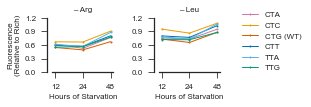

In [17]:

conditions = ['-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['CTA','CTC','WT','CTT','TTA','TTG']


fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,2,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['normalizedMean']
        ax.plot(x, y, marker = 'o', markersize=2, linewidth=1, label = variant.replace("WT","CTG (WT)"))
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 1.2)
    ax.yaxis.set( major_locator = MaxNLocator(4) )
    ax.set_xlabel('Hours of Starvation')
    if axcount == 1:
        ax.set_ylabel('Fluorescence\n(Relative to Rich)')
    if axcount == 2:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([3,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170720_normalizedmean_plustmp_all6leucv_linegraph_coloradj_forpaperv2.svg')
fig.savefig('../figures/20170720_normalizedmean_plustmp_all6leucv_linegraph_coloradj_forpaperv2.pdf',bbox_inches='tight')

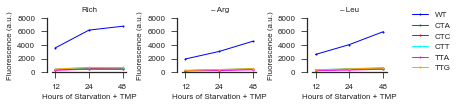

In [32]:

conditions = ['Rich','-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['WT','CTA','CTC','CTT','TTA','TTG']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,3,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['mean']
        ax.plot(x, y, label = variant.replace(variant, variant),marker = 'o',markersize=2,linewidth=1)
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 8000)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation + TMP')
    ax.set_ylabel('Fluorescence (a.u.)')
    #ax.set_xscale('log', basex=2)
    #ax.set_yscale('log', basey=2)
    if axcount == 3:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([6,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170720_rawdatamean_plustmp_all6leucv_linegraph_forpaper.svg')
fig.savefig('../figures/20170720_rawdatamean_plustmp_all6leucv_linegraph_forpaper.pdf',bbox_inches='tight')

mistake is evident here : I used a different LV prep for the WT sample only, and it clearly had a higher MOI. 

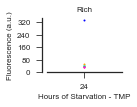

In [37]:

conditions = ['Rich']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0])
variants = ['WT','CTA','CTC','CTT','TTA','TTG']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,3,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataNoTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataNoTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataNoTmp[subset]
        x = xlocations
        y = subsetdata['mean']
        ax.plot(x, y, label = variant.replace(variant, variant),marker = 'o',markersize=2,linewidth=1)
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 350)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation - TMP')
    ax.set_ylabel('Fluorescence (a.u.)')
    if axcount == 3:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([6,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170720_rawdatamean_minustmp_all6leucv_linegraph_forpaper.svg')
fig.savefig('../figures/20170720_rawdatamean_minustmp_all6leucv_linegraph_forpaper.pdf',bbox_inches='tight')

worried that by the 48h time point there might be differential changes in codons in starved relative to rich due to diff seeding densities in rich and thus diff points at which rich conditions hits media depletion & starts accumulating reporter (i.e. CGA) -- repeat w/o letting rich hit confluency?

^ yep , issue fixed by repeating 48 h time point w/ same settings / cells!

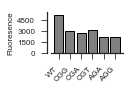

In [111]:
conditions = ['Rich']
times = ['12','24','48']
sampleOrder = np.array([52,34,25,43,7,16])
xlocations =np.array([0,1,2,3,4,5])
variants = ['WT','CGG','CGA','CGT','AGA','AGG']

fig = plt.figure()
ax = fig.add_subplot(111)



ax.bar(xlocations, summarizedDataTmp['mean'][sampleOrder], align='center', facecolor = 'grey',edgecolor='black',linewidth=1 )
#ax.errorbar(xlocations, data['relative_s35met'][sampleOrder], 
            #data['sem'][sampleOrder], linestyle='None', color = 'black', elinewidth=0.5, capsize=2, capthick=0.5 )

spineOffset = {'left': 4, 'bottom': 0}   
[ spine.set_position(('outward',spineOffset[loc])) 
     if loc in ['left','bottom'] else spine.set_color('none') 
     for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )
ax.set_ylim(0,5500)
ax.set_xticks(xlocations)
xticklabels= variants
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

ax.set_ylabel( 'Fluoresence')

fig.set_size_inches([1.29,.75])

fig.savefig('../figures/rawdata_rich_plustmp_24h.svg')
